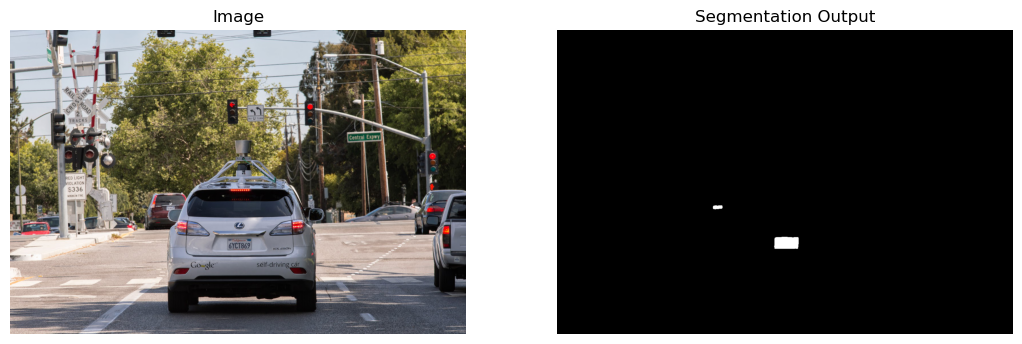

In [1]:
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms
import numpy as np

import sys
sys.path.append("C:/Users/ozhyb/licenseplate-segmentation")
from model import create_model
import utils

%load_ext autoreload
%autoreload 2

def plot(img, pred, threshold=0.5):
    plt.figure(figsize=(20, 20))
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(pred.cpu().numpy()[0] > threshold, cmap='gray')
    plt.title('Segmentation Output')
    plt.axis('off')

def pred(image, model):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)
    
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]
        return output

def show_images(images, cols=1, prefix='Image ', titles=None):
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None:
        titles = [f'{prefix} ({i})' for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, int(np.ceil(n_images / float(cols))), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

model = create_model(outputchannels=1, aux_loss=False)

checkpoint = torch.load('C:/Users/ozhyb/licenseplate-segmentation/output/model_99.pth', map_location='cpu')
state_dict = checkpoint['model']

filtered_state_dict = {k: v for k, v in state_dict.items() if 'aux_classifier' not in k}

model.load_state_dict(filtered_state_dict, strict=False)
_ = model.eval()

if torch.cuda.is_available():
    model.to('cuda')

image_path = 'C:/Users/ozhyb/Desktop/Test.jpg'
image = Image.open(image_path).convert('RGB')

outputs = pred(image=image, model=model)

plot(image, outputs, threshold=0.1)

mask = outputs.cpu().numpy()[0] > 0.1
mask = mask.astype(np.uint8)


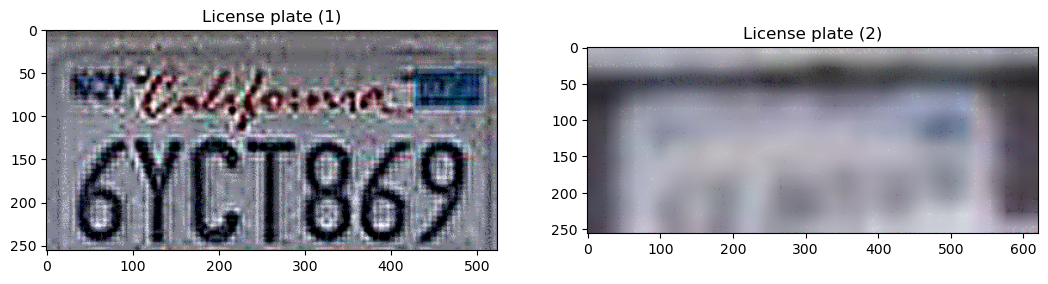

In [2]:
license_plates = utils.extract_segmentation_results(image, mask, sharpen_amount=50)
show_images(license_plates, prefix='License plate')